In [33]:
import glob

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from astropy.io import fits


In [34]:
import argparse
import glob
import importlib
import os
import time

In [35]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from plotly import subplots
from plotly  import __version__
print(__version__)

py.offline.init_notebook_mode(connected=True)

4.4.1


In [36]:
#%matplotlib notebook
%matplotlib inline

import matplotlib.pylab as plt


In [37]:
from gplot import *
gplot.tmp = '$'
gplot.colors('classic')
from pause import pause

In [38]:
from inst.inst_TLS import Spectrum, Tpl, FTS
import vpr


In [39]:
import numpy as np
from scipy import interpolate


c = 3e5   # [km/s] speed of light

# IP sampling in velocity space
# index k for IP space
def IP(vk, s=2.2):
    IP_k = np.exp(-(vk/s)**2)   # Gauss IP
    #IP_k += 0.07*np.exp(-((vk+1.)/s)**2)   # an asymmetry Gauss IP
    IP_k /= IP_k.sum()          # normalise IP
    return IP_k

def IP_sg(vk, s=2.2, e=2.):
    # super Gaussian
    IP_k = np.exp(-abs(vk/s)**e)   # Gauss IP
    IP_k /= IP_k.sum()          # normalise IP
    return IP_k

def IP_mg(vk, s):
    ''' IP for multiple, zero-centered Gaussians '''
    print(s)
    s0, a1, s1 = s
    IP_k = np.exp(-(vk/s0)**2)   # Gauss IP
    IP_k += a1*np.exp(-(vk/s1)**2)   # Gauss IP
    IP_k /= IP_k.sum()          # normalise IP
    return IP_k

IPs = {'g':IP, 'sg': IP_sg,'mg':IP_mg}

class model:
    '''
    The forward model
    
    '''
    def __init__(self, *args, IP_hs=50, icen=0):
        # IP_hs: Half size of the IP (number of sampling knots).
        # icen : Central pixel (to center polynomial for numeric reason).
        self.icen = icen
        self.S_star, self.xj, self.iod_j, self.IP = args
        # convolving with IP will reduce the valid wavelength range
        self.dx = self.xj[1] - self.xj[0]  # sampling in uniform resampled Iod
        self.vk = np.arange(-IP_hs,IP_hs+1) * self.dx * c
        self.xj_eff = self.xj[IP_hs:-IP_hs]
        #print("sampling [km/s]:", self.dx*c)
        
    def __call__(self, i, v, a, b, s):
        # wavelength solution 
        #    lam(x) = b0 + b1 * x + b2 * x^2
        xi = np.log(np.poly1d(b[::-1])(i-self.icen))

        # IP convolution
        Sj_eff = np.convolve(self.IP(self.vk, *s), self.S_star(self.xj-v/c) * self.iod_j, mode='valid')

        # sampling to pixel
        Si_eff = interpolate.interp1d(self.xj_eff, Sj_eff)(xi)

        # flux normalisation
        Si_mod = np.poly1d(a[::-1])(i-self.icen) * Si_eff
        return Si_mod    
    
    def show(self, p, x, y, res=True, x2=None, dx=None):
        '''
        res: Show residuals.
        x2: Values for second x axis.
        dx: Subpixel step size for the model [pixel].

        '''
        ymod = self(x, *p)
        x2 = np.poly1d(p[2][::-1])(x)
        
        trace0 = go.Scatter(x=x,
                   y=y,
                   mode='markers+lines',
                   name='data',
                   marker=dict(size=12,color='rgba(155,60,0,0.5)'))
        trace1 = go.Scatter(x=x,
                   y=ymod,
                   mode='markers+lines',
                   name='model',
                   marker=dict(size=12,color='rgba(55,60,155,0.8)'))

        


        
        prms = np.nan   # percentage prms
        if dx:
            xx = np.arange(x.min(), x.max(), dx)
            xx2 = np.poly1d(p[2][::-1])(xx)
            yymod = self(xx, *p)
            tracedx = go.Scatter(x=xx,
                   y=yymod,
                   mode='markers',
                   name='residual spectrum',
                   marker=dict(size=12,color='rgba(0,190,255,0.9)'))

            fig = subplots.make_subplots(rows=2,
                                     cols=1,
                                     subplot_titles=('Model','residual'),shared_xaxes=True)

            fig.append_trace(trace0,1,1)
            fig.add_trace(trace1,1,1)

            fig.append_trace(tracedx,2,1)

            fig.layout.update(title="Model of the spectrum")

            iplot(fig)        
        elif res:
            rms = np.std(y-ymod)
            prms = rms / np.mean(ymod) * 100
            # overplot residuals
            
            traceres = go.Scatter(x=x,
                               y=y-ymod,
                               mode='markers',
                               name='residual spectrum',
                               marker=dict(size=12,color='rgba(0,190,255,0.9)'))
            
            fig = subplots.make_subplots(rows=3,
                                     cols=1,
                                     subplot_titles=('Model','residual'),shared_xaxes=True)

            fig.append_trace(trace0,1,1)
            fig.add_trace(trace1,1,1)

            fig.append_trace(tracedx,2,1)
            fig.append_trace(traceres,3,1)

            fig.layout.update(title="Model of the spectrum")

            iplot(fig)      
        else:
            fig = subplots.make_subplots(rows=1,
                                 cols=1,
                                 subplot_titles=('Model','residual'))

            fig.append_trace(trace0,1,1)
            fig.add_trace(trace1,1,1)


            fig.layout.update(title="Model of the spectrum")

            iplot(fig)        

            
        return prms


def show_model(x, y, ymod, res=True,x2=1):
    if res:
        rms = np.std(y-ymod)

        trace0 = go.Scatter(x=x,
                   y=y,
                   mode='markers+lines',
                   name='observed',
                   marker=dict(size=12,color='rgba(155,60,0,0.5)'))
        trace1 = go.Scatter(x=x,
                   y=ymod,
                   mode='markers+lines',
                   name='modelled',
                   marker=dict(size=12,color='rgba(55,60,155,0.8)'))

        trace2 = go.Scatter(x=x,
                           y=y-ymod,
                           mode='markers',
                           name='residual spectrum',
                           marker=dict(size=12,color='rgba(0,190,255,0.9)'))

        fig = subplots.make_subplots(rows=2,
                                 cols=1,
                                 subplot_titles=('Model','residual'),shared_xaxes=True)

        fig.append_trace(trace0,1,1)
        fig.add_trace(trace1,1,1)

        fig.append_trace(trace2,2,1)

        fig.layout.update(title="Modelling of the spectrum")

        iplot(fig)
        
    else:
        rms = np.std(y-ymod)

        trace0 = go.Scatter(x=x,
                   y=y,
                   mode='markers+lines',
                   name='observed',
                   marker=dict(size=12,color='rgba(155,60,0,0.5)'))
        trace1 = go.Scatter(x=x,
                   y=ymod,
                   mode='markers+lines',
                   name='modelled',
                   marker=dict(size=12,color='rgba(55,60,155,0.8)'))


        fig = subplots.make_subplots(rows=1,
                                 cols=1,
                                 subplot_titles=('Model'),shared_xaxes=True)

        
        fig.append_trace(trace0,1,1)
        fig.add_trace(trace1,1,1)


        fig.layout.update(title="Modelling of the spectrum")

        iplot(fig)

In [40]:
c = 3e5   # [km/s] speed of light


dirname = r''
ftsname = dirname + 'lib/TLS/FTS/TLS_I2_FTS.fits'
obsname = dirname + 'data/TLS/betgem/BETA_GEM.fits'
tplname = dirname + 'data/TLS/betgem/pepsib.20150409.000.sxt.awl.all6'
obsname = dirname + 'data/TLS/hd189733/TV00001.fits'
tplname = dirname + 'data/TLS/Deconv/HD189733.model'
tplname = dirname + 'data/TLS/Deconv/HARPS.2006-09-08T02:12:38.604_s1d_A.fits'



In [41]:
o = 20
nset = None
targ = None
modset = {}   # model setting parameters

In [42]:
####  FTS  ####

# using the supersampled log(wavelength) space with knot index j

w_I2, f_I2, xj_full, iod_j_full = FTS()



In [43]:

orders = np.r_[20:21] # np.arange(18,30)
print(orders)


[20]


In [44]:
rv = np.nan * orders
e_rv = np.nan * orders


In [45]:
obsname = '/home/sireesha/Desktop/TLS_model/stage10/VIPER/data/TLS/hd189733/TV00001.fits'

In [46]:
tplname='/home/sireesha/Desktop/TLS_model/stage10/VIPER/data/TLS/Deconv/HARPS.2006-09-08T02:12:38.604_s1d_A.fits'

In [47]:
####  data TLS  ####
w, f, bp, bjd, berv = Spectrum(obsname, o=o, targ=targ)
i = np.arange(f.size)




In [48]:
mskatm = interp1d(*np.genfromtxt('lib/mask_vis1.0.dat').T)
bp[mskatm(w) > 0.1] |= 16
i_ok, = np.where(bp==0)

In [49]:
####  stellar template  ####
w_tpl, f_tpl = Tpl(tplname, o=o)

lmin = max(w_tpl[0], w[0], w_I2[0])
lmax = min(w_tpl[-1], w[-1], w_I2[-1])

# display
# pre-look raw input
s = slice(*np.searchsorted(w_I2, [lmin, lmax]))
s_s = slice(*np.searchsorted(w_tpl, [lmin, lmax]))


In [50]:
modset['icen'] = icen = np.mean(i_ok) + 18   # slight offset, then it converges for CES+TauCet

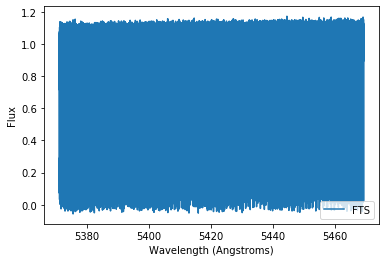

In [51]:
plt.plot(w_I2[s], f_I2[s], label='FTS')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()

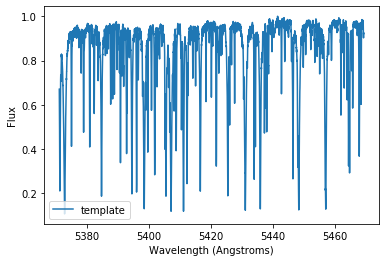

In [52]:
s_s = slice(*np.searchsorted(w_tpl, [lmin, lmax]))

plt.plot(w_tpl[s_s], f_tpl[s_s]/np.max(f_tpl[s_s]), label='template')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()

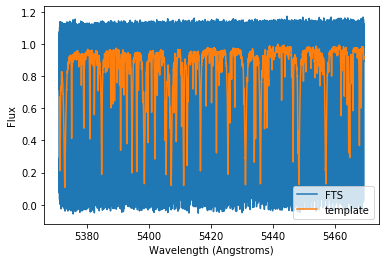

In [53]:
plt.plot(w_I2[s], f_I2[s], label='FTS')
plt.plot(w_tpl[s_s], f_tpl[s_s]/np.max(f_tpl[s_s]), label='template')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()

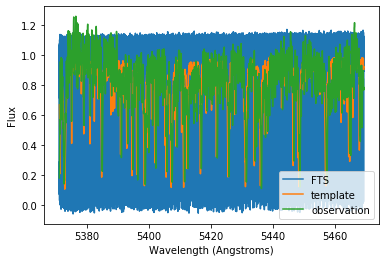

In [54]:
plt.plot(w_I2[s], f_I2[s], label='FTS')
plt.plot(w_tpl[s_s], f_tpl[s_s]/np.max(f_tpl[s_s]), label= 'template')
plt.plot(w, f, label='observation')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()


In [55]:
vcut = 30
sj = slice(*np.searchsorted(xj_full, [np.log(lmin)+vcut/c, np.log(lmax)-vcut/c])) # reduce range by 100 km/s

# prepare input; convert discrete data to model

# using the supersampled log(wavelength) space with knot index j
xj = xj_full[sj]
iod_j = iod_j_full[sj]


In [56]:
# convert discrete template into a function
S_star = interp1d(np.log(w_tpl)-berv/c, f_tpl)

In [57]:
# setup the model
IP = IPs['g']


In [58]:
S_mod = model(S_star, xj, iod_j, IP)
S_mod = model(S_star, xj, iod_j, IP, **modset)

In [59]:
trace=go.Scatter(x=S_mod.vk,
                y=S_mod.IP(S_mod.vk),
                mode='lines+markers',
                marker=dict(size=16))

data=[trace]

layout={'title':'IP interms of velocity sampling','xaxis':{'zeroline':False}}

iplot({'data':data,'layout':layout})

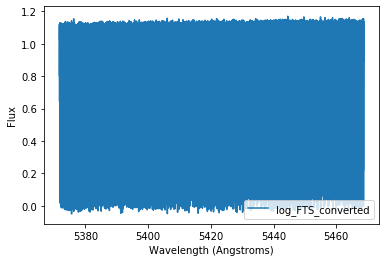

In [60]:
plt.plot(np.exp(xj), iod_j, label='log_FTS_converted')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()


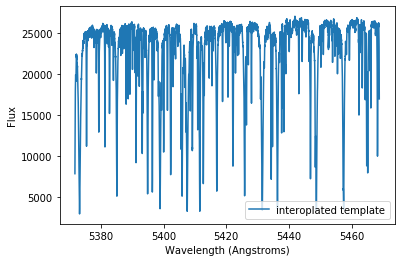

In [61]:
plt.plot(np.exp(xj),S_star(xj), label= 'interoplated template')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.legend()


In [62]:
# trim the observation to a range valid for the model
bp[np.log(w) < xj[0]+100/c] |= 1
bp[np.log(w) > xj[-1]-100/c] |= 1
i_ok = np.where(bp==0)

In [63]:
vg =0
ip='g'

In [65]:
# a parameter set
v = vg   # a good guess for the stellar RV is needed
a = ag = [np.mean(f[i_ok]) / np.mean(S_star(np.log(w[i_ok]))) / np.mean(iod_j)] 
b = bg = [w[0], (w[-1]-w[0])/w.size] # [6128.8833940969, 0.05453566108124]
b = bg = np.polyfit(i[i_ok]-icen, w[i_ok], 3)[::-1]
#show_model(i[i_ok], f[i_ok], S_b(i[i_ok],*bg), res=False)
s = sg = [1.] if ip=='g' else [0.7, 2.]

In [68]:
S_mod.show([v,a,b,s], i[i_ok], f[i_ok], res=True, dx=0.1)

nan

In [69]:
# A wrapper to fit the continuum
S_a = lambda x, a0: S_mod(x, vg, [a0], bg, sg)
a, e_a = curve_fit(S_a, i[i_ok], f[i_ok])
show_model(i[i_ok], f[i_ok], S_a(i[i_ok],*a), res=True)

In [70]:
# A wrapper to fit the wavelength solution
S_b = lambda x, *b: S_mod(x, vg, a, b, sg)
b, e_b = curve_fit(S_b, i[i_ok], f[i_ok], p0=bg)
show_model(i[i_ok], f[i_ok], S_b(i[i_ok], *bg))


In [71]:
show_model(i[i_ok], f[i_ok], S_b(i[i_ok], *b))

In [72]:
# fit v, a and b simultaneously
S_vab = lambda x, v, a, *b: S_mod(x, v, [a], b, sg)
p_vab, e_p = curve_fit(S_vab, i[i_ok], f[i_ok], p0=[v, 1, *bg])
show_model(i[i_ok], f[i_ok], S_vab(i[i_ok], *p_vab))


/home/sireesha/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



In [91]:
S_modg = model(S_star, xj, iod_j, IPs['g'], **modset)
S_g = lambda x, v, a0,a1,a2,a3, b0,b1,b2,b3, *s: S_modg(x, v, [a0,a1,a2,a3], [b0,b1,b2,b3], s[0:1])
p, e_p = curve_fit(S_g, i[i_ok], f[i_ok], p0=[v]+a+[0]*3+[*bg]+s[0:1], epsfcn=1e-12)

ValueError: operands could not be broadcast together with shapes (3,) (4,) 